In [2]:
import os
from collections import Counter
import pickle
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import Input, Model, layers, losses, optimizers, callbacks
from tensorflow.keras.datasets import mnist

from matplotlib import pyplot as plt

(10000, 784)
(10000, 784)
Counter({1: 1113, 7: 1044, 6: 1020, 3: 1013, 8: 994, 2: 981, 0: 980, 9: 969, 4: 964, 5: 922})


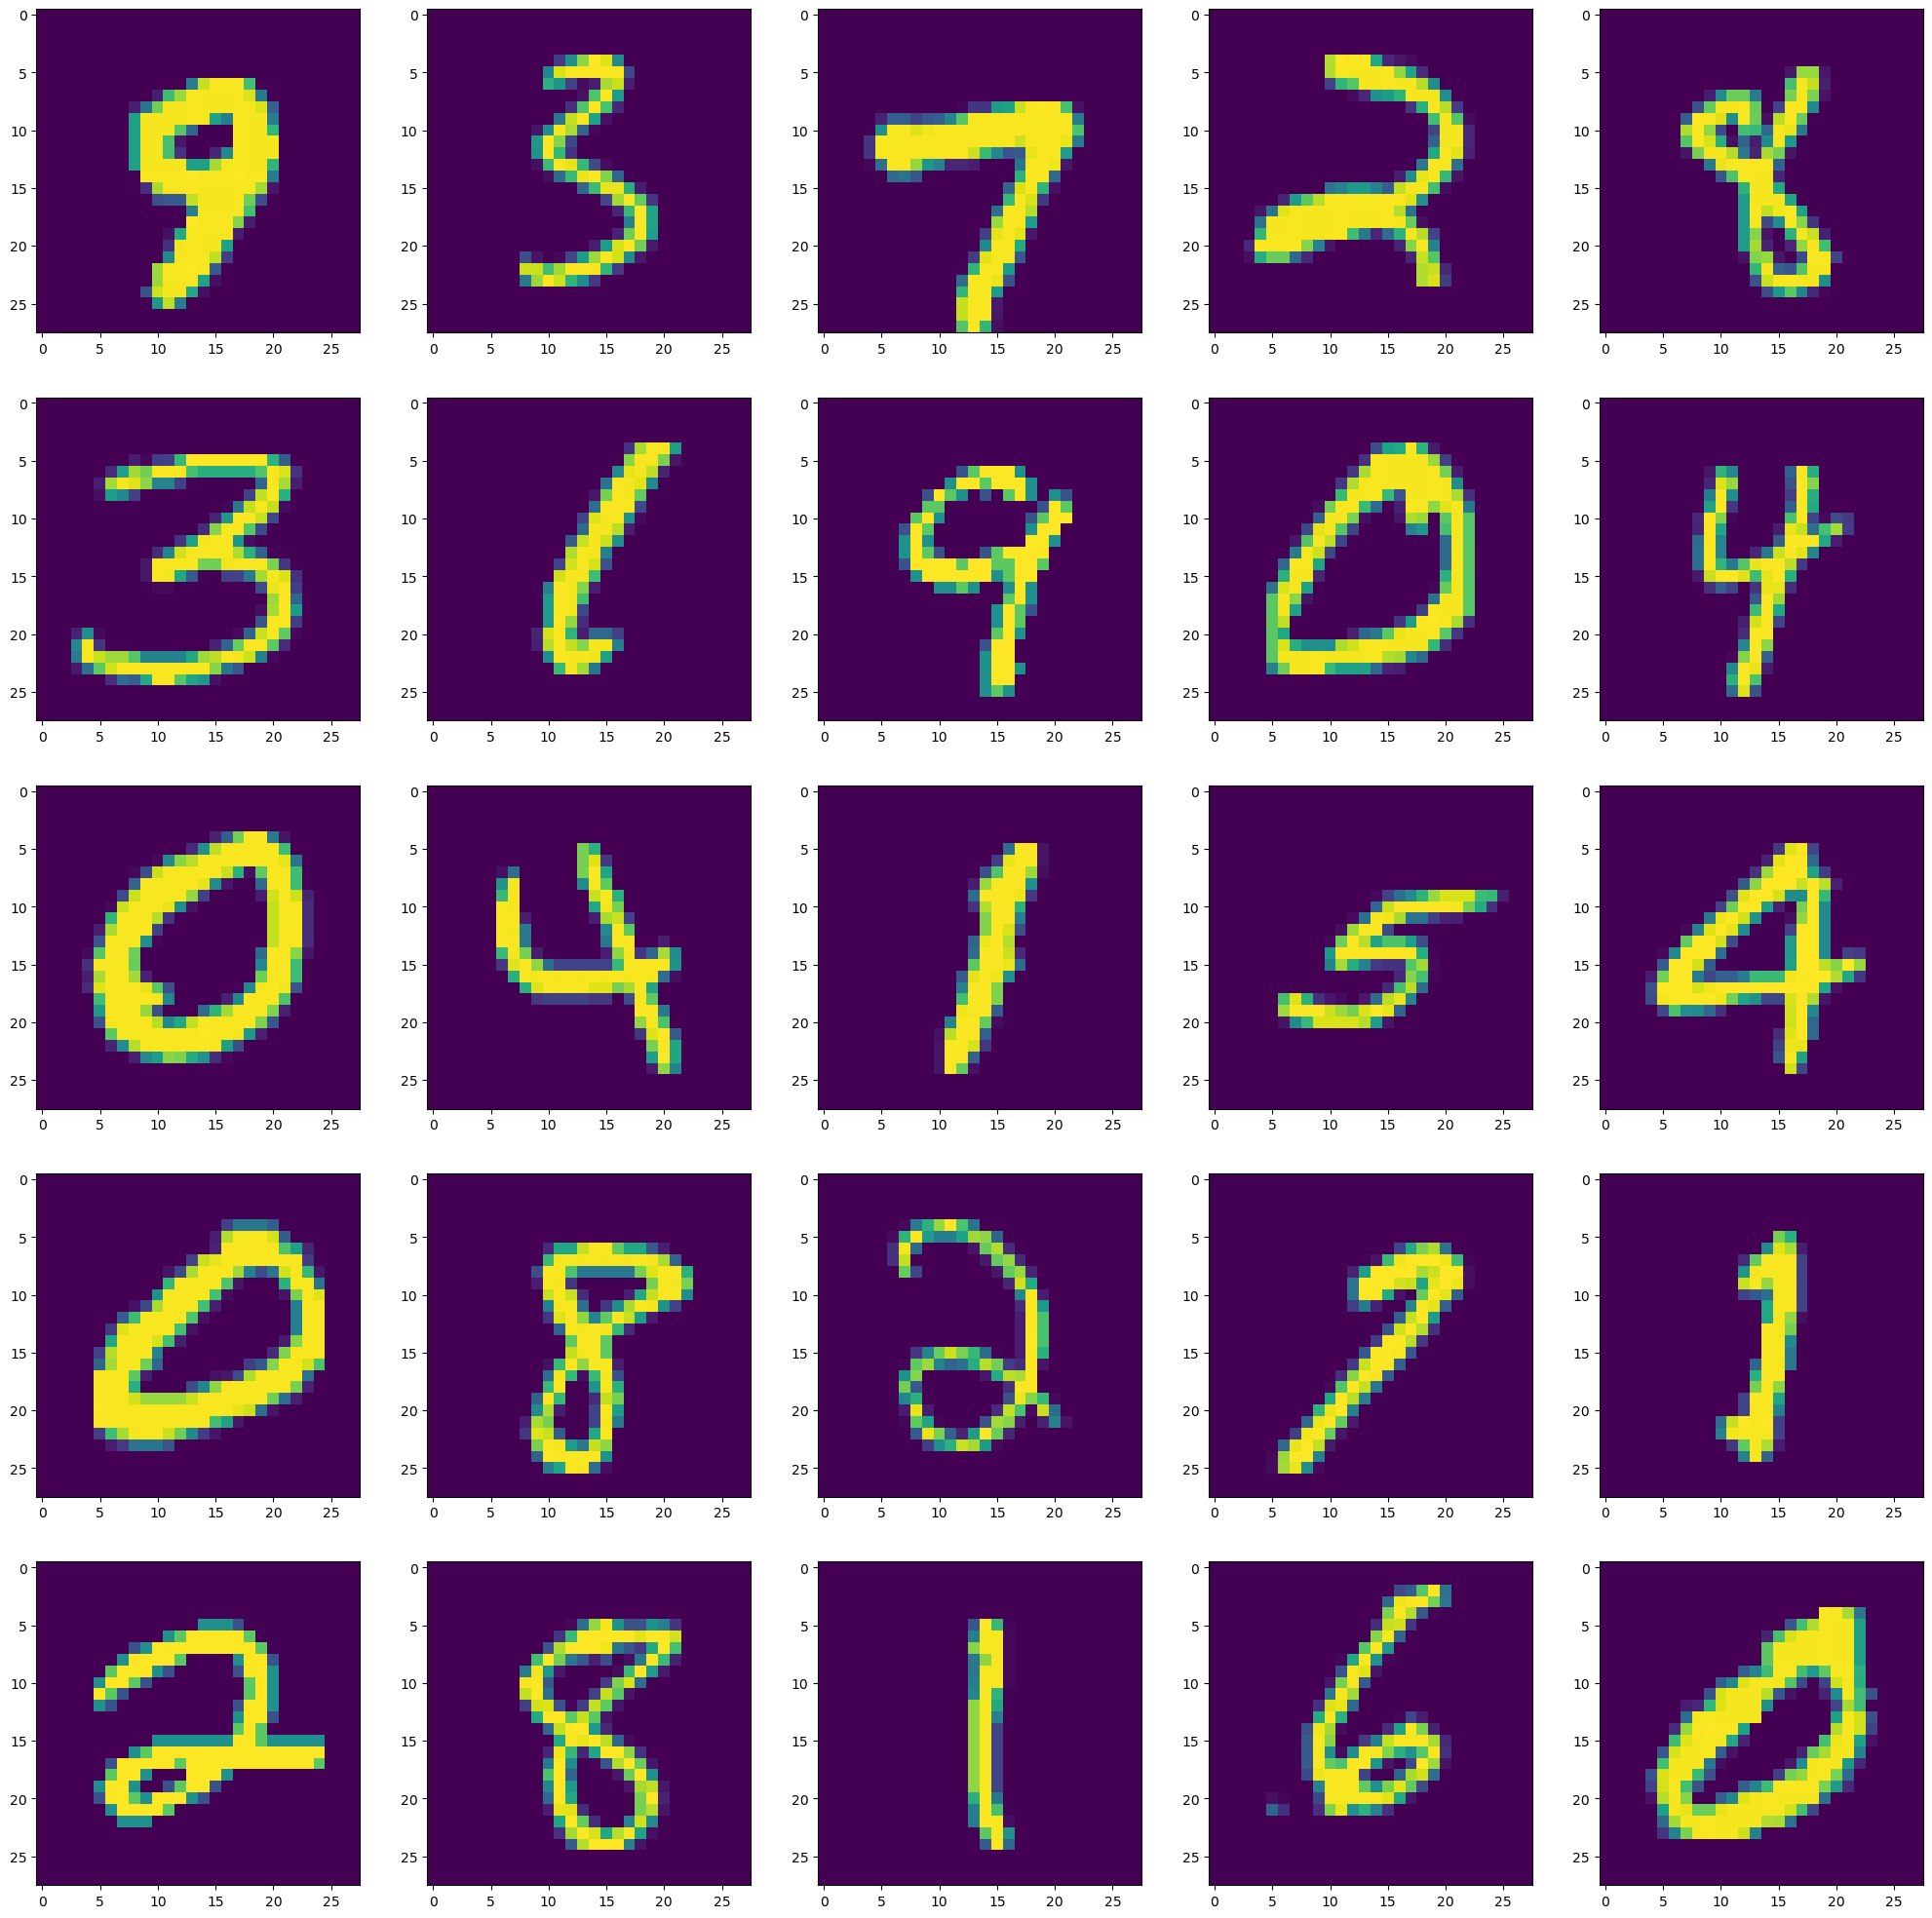

In [7]:
# load data
(xtrain_, ytrain), (xtest, ytest) = mnist.load_data()

# preprocessing: rescaling, reshaping
def preprocess_images(x):
    return x.astype("float32") / 255.

xtrain = preprocess_images(xtrain_)

# Spilt some dta for training/validation/testing
Xtrain_, Xrest_, Ytrain, Yrest_ = train_test_split(xtrain, ytrain, train_size=10000)
Xval_, Xrest_, Yval, Yrest_ = train_test_split(Xrest_, Yrest_, train_size=1000)
Xtest_, Xrest_, Ytest, Yrest_ = train_test_split(Xrest_, Yrest_, train_size=10000)

#plot some examples
idxs = np.random.choice(len(Xtrain_), 25, replace=False)
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
for idx, ax in zip(idxs, axs.flatten()):
    ax.imshow(Xtrain_[idx])
    
# sklearn need the format n_samples * n_feature
Xtrain = Xtrain_.reshape((Xtrain_.shape[0], -1))
Xtest = Xtest_.reshape((Xtest_.shape[0], -1))
print(Xtrain.shape)
print(Xtest.shape)
print(Counter(Ytrain))

In [8]:
# train a classifier
LR = LogisticRegression(max_iter=1000)
LR.fit(Xtrain, Ytrain)

LogisticRegression(max_iter=1000)

In [9]:
# evaluate trained classifier on test set
Ypred = LR.predict(Xtest)
print(classification_report(Ytest, Ypred))
print(confusion_matrix(Ytest, Ypred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       944
           1       0.93      0.96      0.95      1153
           2       0.89      0.87      0.88       989
           3       0.89      0.87      0.88      1061
           4       0.90      0.92      0.91       977
           5       0.85      0.84      0.85       931
           6       0.93      0.93      0.93       986
           7       0.91      0.92      0.92      1033
           8       0.87      0.84      0.85       991
           9       0.86      0.89      0.88       935

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

[[ 894    0   11    1    4   15    7    3    7    2]
 [   0 1112    7    4    1    8    0    2   15    4]
 [   8   18  857   28   16    6   18   13   22    3]
 [   2    9   26  921    1   48    5   12   23   14]
 [   1    5    9    3  896   

In [10]:
# try a better model
RF = RandomForestClassifier()
RF.fit(Xtrain, Ytrain)

RandomForestClassifier()

In [16]:
# evaluate trained classifier on test set
Ypred2 = RF.predict(Xtest)
print(classification_report(Ytest, Ypred2))
print(confusion_matrix(Ytest, Ypred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       944
           1       0.97      0.98      0.98      1153
           2       0.94      0.93      0.94       989
           3       0.94      0.92      0.93      1061
           4       0.96      0.95      0.95       977
           5       0.95      0.94      0.94       931
           6       0.96      0.97      0.97       986
           7       0.96      0.96      0.96      1033
           8       0.94      0.93      0.93       991
           9       0.92      0.94      0.93       935

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

[[ 894    0   11    1    4   15    7    3    7    2]
 [   0 1112    7    4    1    8    0    2   15    4]
 [   8   18  857   28   16    6   18   13   22    3]
 [   2    9   26  921    1   48    5   12   23   14]
 [   1    5    9    3  896   

In [14]:
# Hyperparameter tuning
param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [None, 10, 50],
    "max_features": ["sqrt", "log2", .1]
}

RF_tuned = GridSearchCV(RandomForestClassifier(),
                        param_grid=param_grid,
                        cv=4,
                        n_jobs=-1,
                        verbose=4
                       )
RF_tuned.fit(Xtrain, Ytrain)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 50],
                         'max_features': ['sqrt', 'log2', 0.1],
                         'n_estimators': [200, 500]},
             verbose=4)

In [15]:
# display crossvalidation results
cv_results = pd.DataFrame(RF_tuned.cv_results_)
disp_cols = ["param_n_estimators", "param_max_depth", "param_max_features", "mean_fit_time", "mean_test_score"]
mapper = dict(zip(disp_cols[:3], ["n_estimators", "max_depth", "max_features"]))
renamed_df = cv_results[disp_cols].copy()
renamed_df.rename(columns=mapper, inplace=True)
print(renamed_df.sort_values("mean_test_score", ascending=False))
                  
                  

   n_estimators max_depth max_features  mean_fit_time  mean_test_score
15          500        50         log2       6.419794           0.9464
13          500        50         sqrt      14.894474           0.9451
3           500      None         log2       6.495494           0.9448
0           200      None         sqrt       6.038726           0.9444
1           500      None         sqrt      15.679079           0.9443
17          500        50          0.1      33.561799           0.9436
5           500      None          0.1      39.822721           0.9434
12          200        50         sqrt       6.006391           0.9427
2           200      None         log2       2.597575           0.9425
4           200      None          0.1      14.959187           0.9422
14          200        50         log2       2.586525           0.9416
16          200        50          0.1      15.129450           0.9405
7           500        10         sqrt      12.627249           0.9331
11    

In [19]:
# evaluate trained classifier on test set
print(RF_tuned.best_params_)
Ypred3 = RF_tuned.predict(Xtest)
print(classification_report(Ytest, Ypred3))
print(confusion_matrix(Ytest, Ypred3))

{'max_depth': 50, 'max_features': 'log2', 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       944
           1       0.97      0.98      0.98      1153
           2       0.95      0.95      0.95       989
           3       0.95      0.93      0.94      1061
           4       0.95      0.95      0.95       977
           5       0.96      0.94      0.95       931
           6       0.95      0.98      0.97       986
           7       0.96      0.96      0.96      1033
           8       0.95      0.93      0.94       991
           9       0.92      0.94      0.93       935

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

[[ 932    0    0    0    0    0    6    0    5    1]
 [   0 1133    7    2    4    2    0    0    3    2]
 [   4    3  937    6   11    1    7    8   10    2]
 [   3    1   19  9

In [20]:
# Convolutional Neural Network in tensorflow using Keras API

def mnist_clf(input_shape=(28, 28, 1), n_classes=10):
    inx = Input(input_shape)
    x = layers.Conv2D(32, kernel_size=(3,3), strides=2, padding="same", activation="relu")(inx)
    x = layers.Conv2D(64, kernel_size=(3,3), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, kernel_size=(3,3), strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(n_classes)(x)
    return Model(inx, x)

clf_mnist = mnist_clf()
clf_mnist.summary()

# select loss function and optimizer
loss = losses.CategoricalCrossentropy(from_logits=True)
opt = optimizers.Nadam(learning_rate=1e-2)
clf_mnist.compile(loss=loss,
                  optimizer=opt,
                  metrics=["accuracy"]
                 )

# preprocess data: scaling of imaegs, one-hot encoding of labels
def preprocess_tf(x, y):
    return x, tf.one_hot(y, depth=10, axis=-1)

trainset = tf.data.Dataset.from_tensor_slices((Xtrain_, Ytrain)).shuffle(Xtrain_.shape[0]).batch(256).map(preprocess_tf)
valset = tf.data.Dataset.from_tensor_slices((Xval_, Yval)).batch(1000).map(preprocess_tf)

# callback for saving model
MdlCpt = callbacks.ModelCheckpoint("convert_mnist_prac", save_best_only=True)
                  
                  
    

Metal device set to: Apple M1 Pro
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)           

2022-11-19 13:59:34.780316: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-19 13:59:34.780505: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Trainable params: 356,234
Non-trainable params: 0
_________________________________________________________________


In [24]:
hist = clf_mnist.fit(trainset,
                     validation_data=valset,
                     epochs=100,
                     callbacks=[MdlCpt]
                    )


Epoch 1/100
40/40 [==============================] - 1s 26ms/step - loss: 0.0085 - accuracy: 0.9972 - val_loss: 0.1157 - val_accuracy: 0.9740
Epoch 2/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.9695 - val_accuracy: 0.9010
Epoch 3/100
40/40 [==============================] - 1s 25ms/step - loss: 0.1037 - accuracy: 0.9744 - val_loss: 0.1154 - val_accuracy: 0.9690
Epoch 4/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0131 - accuracy: 0.9957 - val_loss: 0.2249 - val_accuracy: 0.9640
Epoch 5/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0136 - accuracy: 0.9956 - val_loss: 0.1396 - val_accuracy: 0.9720
Epoch 6/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.1533 - val_accuracy: 0.9720
Epoch 7/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.1710 - val_accuracy: 0.9710
Epoch 

Metrics on test set
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       944
           1       0.98      0.99      0.98      1153
           2       0.97      0.98      0.98       989
           3       0.98      0.98      0.98      1061
           4       0.99      0.97      0.98       977
           5       0.98      0.97      0.98       931
           6       0.98      0.98      0.98       986
           7       0.98      0.98      0.98      1033
           8       0.97      0.96      0.97       991
           9       0.96      0.97      0.96       935

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

[[ 936    0    1    0    1    0    2    1    2    1]
 [   0 1140    4    0    2    0    1    2    3    1]
 [   2    5  966    3    1    1    2    5    4    0]
 [   1    0    6 1036    0    6    0    6    4    2]
 [   1   

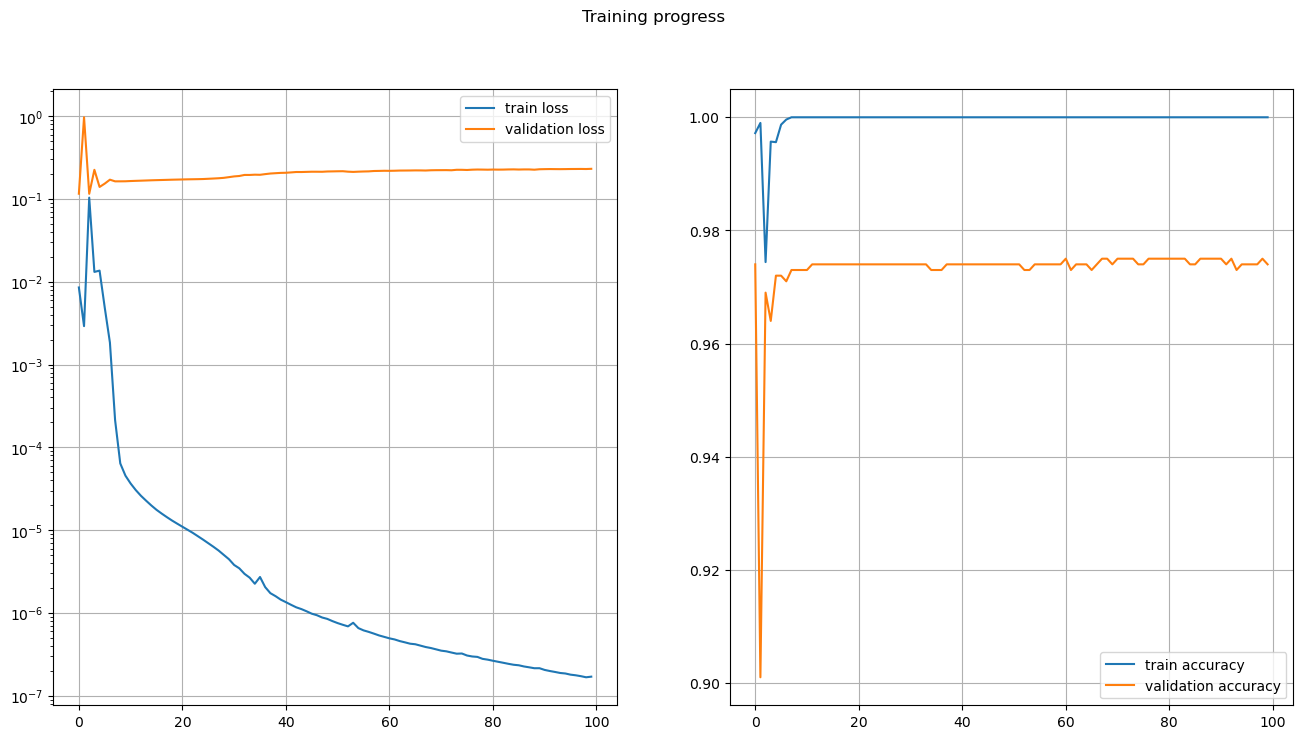

In [25]:
# plot training metrics
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].semilogy(hist.history['loss'], label='train loss')
ax[0].semilogy(hist.history['val_loss'], label='validation loss')
ax[1].plot(hist.history['accuracy'], label='train accuracy');
ax[1].plot(hist.history['val_accuracy'], label='validation accuracy');
ax[0].legend();
ax[1].legend();
ax[1].grid()
ax[0].grid()
fig.suptitle('Training progress')

print('Metrics on test set')

# display results with trained classifier (100 epochs)
Ypred4 = tf.argmax(clf_mnist(Xtest_), axis=-1)

print(classification_report(Ytest, Ypred4))
print(confusion_matrix(Ytest, Ypred4))

In [26]:
clf_mnist.evaluate(Xtest_, tf.one_hot(Ytest, depth=10), verbose=1)

313/313 [==============================] - 3s 8ms/step - loss: 0.2269 - accuracy: 0.9773


[0.22687557339668274, 0.9773000478744507]

In [27]:
# load best model from checkpoint
print("Best model found in epoch", np.argmin(hist.history["val_loss"]) + 1)
clf2 = tf.keras.models.load_model("convert_mnist_prac")
Ypred5 = tf.argmax(clf2(Xtest_), axis=-1)
print(classification_report(Ytest, Ypred5))
print(confusion_matrix(Ytest, Ypred5))

Best model found in epoch 3
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       944
           1       0.97      0.99      0.98      1153
           2       0.97      0.97      0.97       989
           3       0.98      0.97      0.97      1061
           4       0.97      0.98      0.98       977
           5       0.98      0.98      0.98       931
           6       0.98      0.98      0.98       986
           7       0.96      0.98      0.97      1033
           8       0.97      0.96      0.96       991
           9       0.97      0.95      0.96       935

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

[[ 941    0    0    0    0    0    2    0    1    0]
 [   0 1141    4    0    2    0    0    2    3    1]
 [   4    7  963    5    4    0    2    3    1    0]
 [   0    1   10 1027    0    5    1    9    7    1]
 